IMPORT DATA

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

nfl_pbp = nfl.import_pbp_data([2023, 2022, 2021, 2020, 2019, 2018])

2023 done.
2022 done.
2021 done.
2020 done.
2019 done.
2018 done.
Downcasting floats.


In [2]:
file_path = '/Users/markstolte/downloads/NFL/nfl_tendency.xlsx'
tendencies = pd.read_excel(file_path)
tendencies['proe'] = tendencies['proe']/100

file_path = '/Users/markstolte/downloads/NFL/nfelo_sos.xlsx'
sos = pd.read_excel(file_path)

CREATE TEAM LEVEL STATS

In [16]:
pbp_rp = nfl_pbp[((nfl_pbp['pass'] == 1) | (nfl_pbp['rush'] == 1))].copy()


pbp_rp.loc[pbp_rp['pass'] == 1, 'pass_success'] = (pbp_rp['epa'] > 0)
pbp_rp.loc[pbp_rp['rush'] == 1, 'rush_success'] = (pbp_rp['epa'] > 0)
pbp_rp['pass_success'] = pbp_rp['pass_success'].astype(bool) # To remove warnings
pbp_rp['rush_success'] = pbp_rp['rush_success'].astype(bool)

pbp_rp['explosive_play'] = ((pbp_rp['pass'] == 1) | (pbp_rp['rush'] == 1)) & (pbp_rp['yards_gained'] > 20)

In [17]:
# Offensive metrics
pass_epa = pbp_rp[pbp_rp['pass'] == 1].groupby(['game_id', 'season', 'week', 'posteam', 'posteam_type'])['epa'].mean().reset_index(name='pass_epa')
rush_epa = pbp_rp[pbp_rp['rush'] == 1].groupby(['game_id', 'season', 'week', 'posteam', 'posteam_type'])['epa'].mean().reset_index(name='rush_epa')
pass_sr = pbp_rp[pbp_rp['pass'] == 1].groupby(['game_id', 'season', 'week', 'posteam', 'posteam_type'])['pass_success'].mean().reset_index(name='pass_sr')
rush_sr = pbp_rp[pbp_rp['rush'] == 1].groupby(['game_id', 'season', 'week', 'posteam', 'posteam_type'])['rush_success'].mean().reset_index(name='rush_sr')
explosive_rate = pbp_rp.groupby(['game_id', 'season', 'week', 'posteam', 'posteam_type'])['explosive_play'].mean().reset_index(name='explosive_rate')


# Combine offensive and defensive metrics into a single DataFrame
combined_metrics = pd.concat([pass_epa, rush_epa, pass_sr, rush_sr, explosive_rate], axis=1)

# Drop duplicate columns that arise from the concat process
combined_metrics = combined_metrics.loc[:, ~combined_metrics.columns.duplicated()]


SEPARATE BY HOME AND AWAY TEAM

In [18]:
# Pivot to separate home and away stats
pivoted_metrics = combined_metrics.pivot_table(index=['game_id', 'season', 'week'],
                                               columns='posteam_type',
                                               values=['pass_epa', 'rush_epa', 'pass_sr', 'rush_sr', 'explosive_rate'
                                                      ])

# Flatten the MultiIndex columns after pivoting
pivoted_metrics.columns = ['_'.join(col).strip() for col in pivoted_metrics.columns.values]

# Reset index to get a clean DataFrame
final_metrics = pivoted_metrics.reset_index()

# Extract home and away teams
home_teams = pbp_rp[pbp_rp['posteam_type'] == 'home'].groupby(['game_id', 'season', 'week'])['posteam'].first().reset_index(name='home_team')
away_teams = pbp_rp[pbp_rp['posteam_type'] == 'away'].groupby(['game_id', 'season', 'week'])['posteam'].first().reset_index(name='away_team')

# Merge home and away teams into the final metrics DataFrame
final_metrics = pd.merge(final_metrics, home_teams, on=['game_id', 'season', 'week'], how='left')
final_metrics = pd.merge(final_metrics, away_teams, on=['game_id', 'season', 'week'], how='left')

# Reorder columns for clarity
final_metrics = final_metrics[['game_id', 'season', 'week', 'home_team', 'away_team'] + [col for col in final_metrics.columns if col not in ['game_id', 'season', 'week', 'home_team', 'away_team']]]


WINS/SCORES

In [19]:
season_data = nfl.import_schedules([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010])


# Replace team names
season_data['home_team'] = season_data['home_team'].replace({'OAK': 'LV', 'SD': 'LAC'})
season_data['away_team'] = season_data['away_team'].replace({'OAK': 'LV', 'SD': 'LAC'})

# Calculate home and away wins
season_data['home_win'] = np.where(season_data['home_score'] > season_data['away_score'], 1, 0)
season_data['away_win'] = np.where(season_data['away_score'] > season_data['home_score'], 1, 0)

# Get unique teams
teams = pd.concat([season_data['home_team'], season_data['away_team']]).unique()


import pandas as pd

# Create a dataframe for home teams
home_df = season_data[['season', 'week', 'home_team', 'home_win']].copy()
home_df.rename(columns={'home_team': 'team'}, inplace=True)

# Create a dataframe for away teams
away_df = season_data[['season', 'week', 'away_team', 'away_win']].copy()
away_df.rename(columns={'away_team': 'team'}, inplace=True)

# Combine the two dataframes
combined_df = pd.concat([home_df, away_df], ignore_index=True)


df = pd.merge(final_metrics, season_data[['season', 'week', 'home_team', 'away_team', 'home_win', 'away_win', 'home_score', 'away_score']], 
              on=['season', 'week', 'home_team', 'away_team'], 
              how='inner')




ELIMINATING LOOK-AHEAD BIAS (LAGGED VARIABLES)

In [29]:
import pandas as pd


df = df.sort_values(by=['season', 'week'])

# List of statistics to average
home_stats = [
    'explosive_rate_home', 'pass_epa_home', 'pass_sr_home',
    'rush_epa_home', 'rush_sr_home'
]
away_stats = [
    'explosive_rate_away', 'pass_epa_away', 'pass_sr_away',
    'rush_epa_away', 'rush_sr_away'
]

# Calculate cumulative sums and counts for home stats
for stat in home_stats:
    df[f'{stat}_cumsum'] = df.groupby(['season', 'home_team'])[stat].transform(lambda x: x.expanding().sum().shift(1))
    df[f'{stat}_count'] = df.groupby(['season', 'home_team'])[stat].transform(lambda x: x.expanding().count().shift(1))

# Calculate cumulative sums and counts for away stats
for stat in away_stats:
    df[f'{stat}_cumsum'] = df.groupby(['season', 'away_team'])[stat].transform(lambda x: x.expanding().sum().shift(1))
    df[f'{stat}_count'] = df.groupby(['season', 'away_team'])[stat].transform(lambda x: x.expanding().count().shift(1))

# Calculate weighted averages for home stats
for stat in home_stats:
    avg_stat = f'{stat}_avg'
    df[avg_stat] = df[f'{stat}_cumsum'] / df[f'{stat}_count']

# Calculate weighted averages for away stats
for stat in away_stats:
    avg_stat = f'{stat}_avg'
    df[avg_stat] = df[f'{stat}_cumsum'] / df[f'{stat}_count']

# Calculate total counts of home and away games
df['home_games_count'] = df.groupby(['season', 'home_team'])['home_team'].transform('count')
df['away_games_count'] = df.groupby(['season', 'away_team'])['away_team'].transform('count')

# Calculate weighted averages for combined stats
df['explosive_rate_avg'] = (df['explosive_rate_home_avg'] * df['home_games_count'] +
                            df['explosive_rate_away_avg'] * df['away_games_count']) / (df['home_games_count'] + df['away_games_count'])
df['pass_epa_avg'] = (df['pass_epa_home_avg'] * df['home_games_count'] +
                      df['pass_epa_away_avg'] * df['away_games_count']) / (df['home_games_count'] + df['away_games_count'])
df['pass_sr_avg'] = (df['pass_sr_home_avg'] * df['home_games_count'] +
                     df['pass_sr_away_avg'] * df['away_games_count']) / (df['home_games_count'] + df['away_games_count'])
df['rush_epa_avg'] = (df['rush_epa_home_avg'] * df['home_games_count'] +
                      df['rush_epa_away_avg'] * df['away_games_count']) / (df['home_games_count'] + df['away_games_count'])
df['rush_sr_avg'] = (df['rush_sr_home_avg'] * df['home_games_count'] +
                     df['rush_sr_away_avg'] * df['away_games_count']) / (df['home_games_count'] + df['away_games_count'])



In [30]:
df[['season', 'week', 'home_team', 'away_team'] + [f'{stat}_avg' for stat in home_stats + away_stats]].head(100)


,season,week,home_team,away_team,explosive_rate_home_avg,pass_epa_home_avg,pass_sr_home_avg,rush_epa_home_avg,rush_sr_home_avg,explosive_rate_away_avg,pass_epa_away_avg,pass_sr_away_avg,rush_epa_away_avg,rush_sr_away_avg
0,2018,1,PHI,ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,1,BAL,BUF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,1,GB,CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,1,IND,CIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,1,CAR,DAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2018,7,KC,CIN,0.064666,0.404218,0.553571,-0.103703,0.336154,0.073966,0.156762,0.529027,0.055572,0.480231
96,2018,7,TB,CLE,0.061038,0.208379,0.534625,-0.346422,0.152098,0.069758,0.008297,0.430743,-0.066438,0.343125
97,2018,7,WAS,DAL,0.050981,0.053797,0.495702,-0.059793,0.371111,0.027693,-0.205065,0.375847,-0.106639,0.374269
98,2018,7,ARI,DEN,0.067265,-0.094643,0.412587,-0.206293,0.329814,0.061020,-0.122287,0.456696,-0.038098,0.390526


In [31]:
df.to_csv('updated_data_with_weighted_averages.csv', index=False)


In [32]:
import pandas as pd

# Sample data
data = pd.Series([1, 2, 3, 4])

# Apply expanding() and mean()
expanding_mean = data.expanding().mean()

print(expanding_mean)


0    1.0
1    1.5
2    2.0
3    2.5
dtype: float64


In [76]:
import pandas as pd
from pycaret.classification import *


# Initialize the PyCaret setup
clf = setup(data=df_lagged, target='win', session_id=123, train_size=0.8,preprocess=True, fold=5, ignore_features=[ 'team', 'away_win', 'home_win'])


,Description,Value
0,Session id,123
1,Target,win
2,Target type,Binary
3,Original data shape,"(3314, 16)"
4,Transformed data shape,"(3314, 13)"
5,Transformed train set shape,"(2651, 13)"
6,Transformed test set shape,"(663, 13)"
7,Ignore features,3
8,Numeric features,12
9,Rows with missing values,100.0%


/Users/markstolte/Library/Python/3.9/lib/python/site-packages/pycaret/internal/metrics.py:51: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [77]:
# Compare models to see performance
best_model = compare_models()

# Create a logistic regression model
logistic_regression_model = create_model('lr')

# Evaluate the logistic regression model
evaluate_model(logistic_regression_model)

# Optionally, finalize the model if you are satisfied with the performance
final_model = finalize_model(logistic_regression_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5077,0.5053,0.4909,0.5059,0.4980,0.0153,0.0153,0.0700
qda,Quadratic Discriminant Analysis,0.5040,0.5101,0.5545,0.5018,0.5246,0.0083,0.0085,0.3620
ridge,Ridge Classifier,0.5021,0.0000,0.4712,0.4996,0.4846,0.0039,0.0039,0.0160
dummy,Dummy Classifier,0.5021,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0140
lda,Linear Discriminant Analysis,0.5013,0.5015,0.4689,0.4981,0.4827,0.0024,0.0022,0.0140
svm,SVM - Linear Kernel,0.4987,0.0000,0.8000,0.3983,0.5318,0.0000,0.0000,0.3580
lightgbm,Light Gradient Boosting Machine,0.4979,0.4940,0.4795,0.4955,0.4867,-0.0043,-0.0043,0.7620
rf,Random Forest Classifier,0.4945,0.5008,0.4636,0.4915,0.4767,-0.0112,-0.0113,0.5020
xgboost,Extreme Gradient Boosting,0.4889,0.4719,0.4833,0.4863,0.4846,-0.0223,-0.0223,0.0580
lr,Logistic Regression,0.4877,0.4865,0.4455,0.4844,0.4640,-0.0249,-0.0250,1.3380


/Users/markstolte/Library/Python/3.9/lib/python/site-packages/pycaret/internal/pycaret_experiment/supervised_experiment.py:323: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  master_display_.apply(


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4859,0.4670,0.4470,0.4816,0.4637,-0.0287,-0.0288
1,0.4830,0.4880,0.4583,0.4802,0.4690,-0.0342,-0.0342
2,0.4755,0.4692,0.4167,0.4701,0.4418,-0.0495,-0.0498
3,0.4887,0.5012,0.4508,0.4857,0.4676,-0.0229,-0.0230
4,0.5057,0.5073,0.4545,0.5042,0.4781,0.0109,0.0110
Mean,0.4877,0.4865,0.4455,0.4844,0.4640,-0.0249,-0.0250
Std,0.0100,0.0163,0.0149,0.0112,0.0121,0.0200,0.0201


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

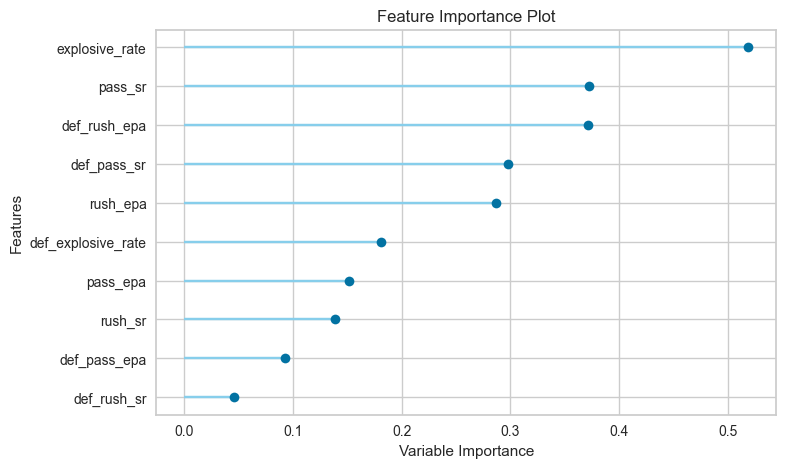

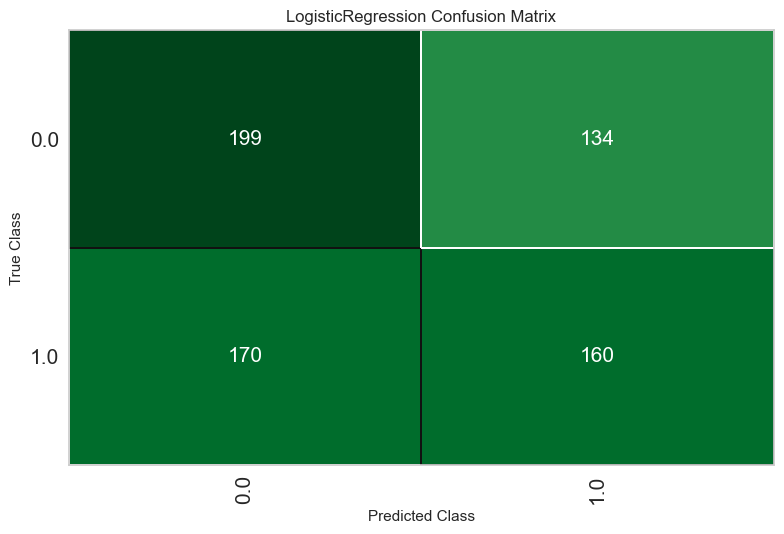

In [78]:
# Plot feature importance
plot_model(logistic_regression_model, plot='feature')

# Plot the confusion matrix
plot_model(logistic_regression_model, plot='confusion_matrix')

# Predict on new data (if available)
# predictions = predict_model(final_model, data=new_data)
